Ventilatory Threshold Results:
VEQ: 3197.0 mL/min
Excess CO2: 3170.0 mL/min
V-Slope: 2810.4 mL/min


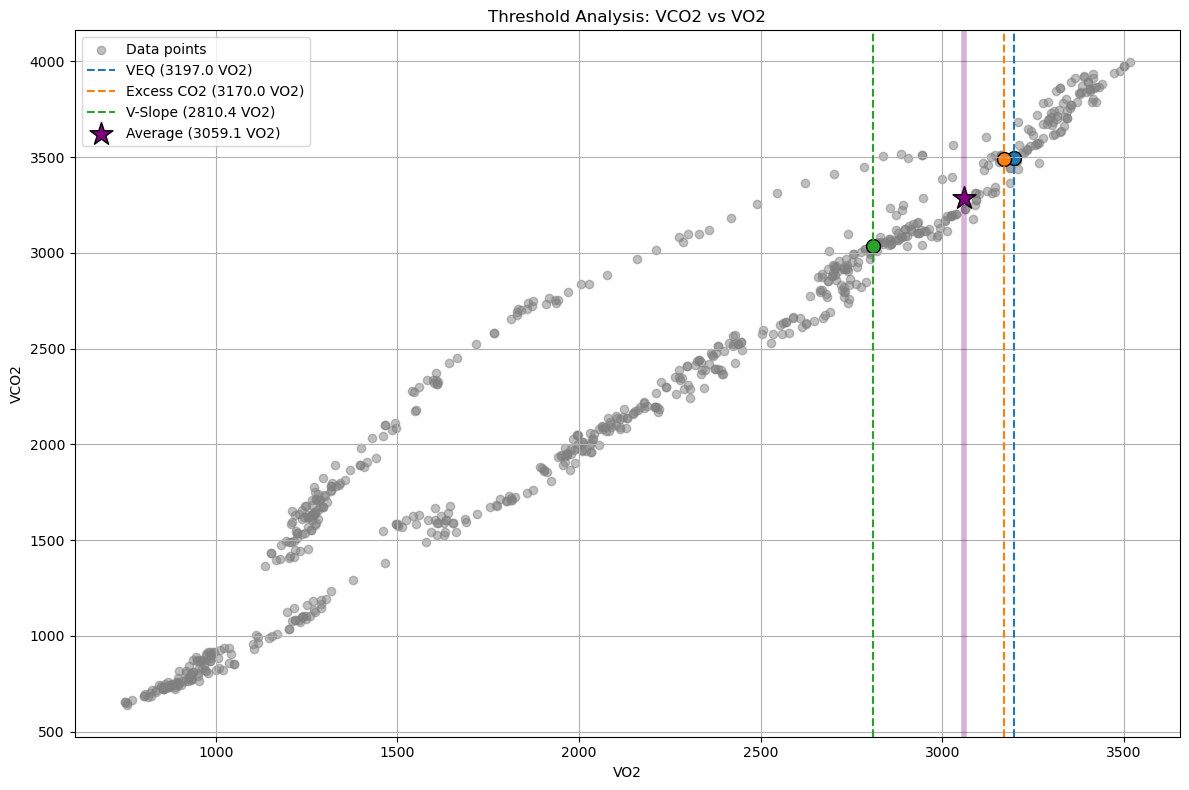

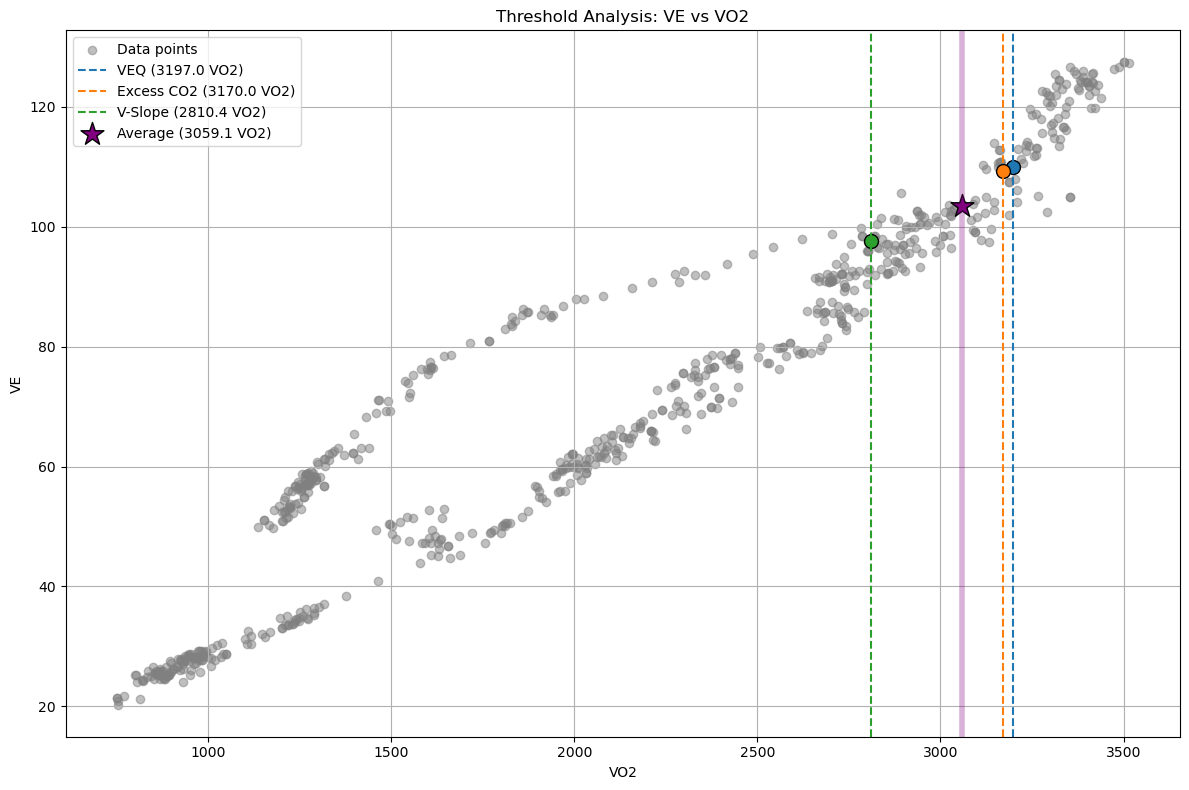

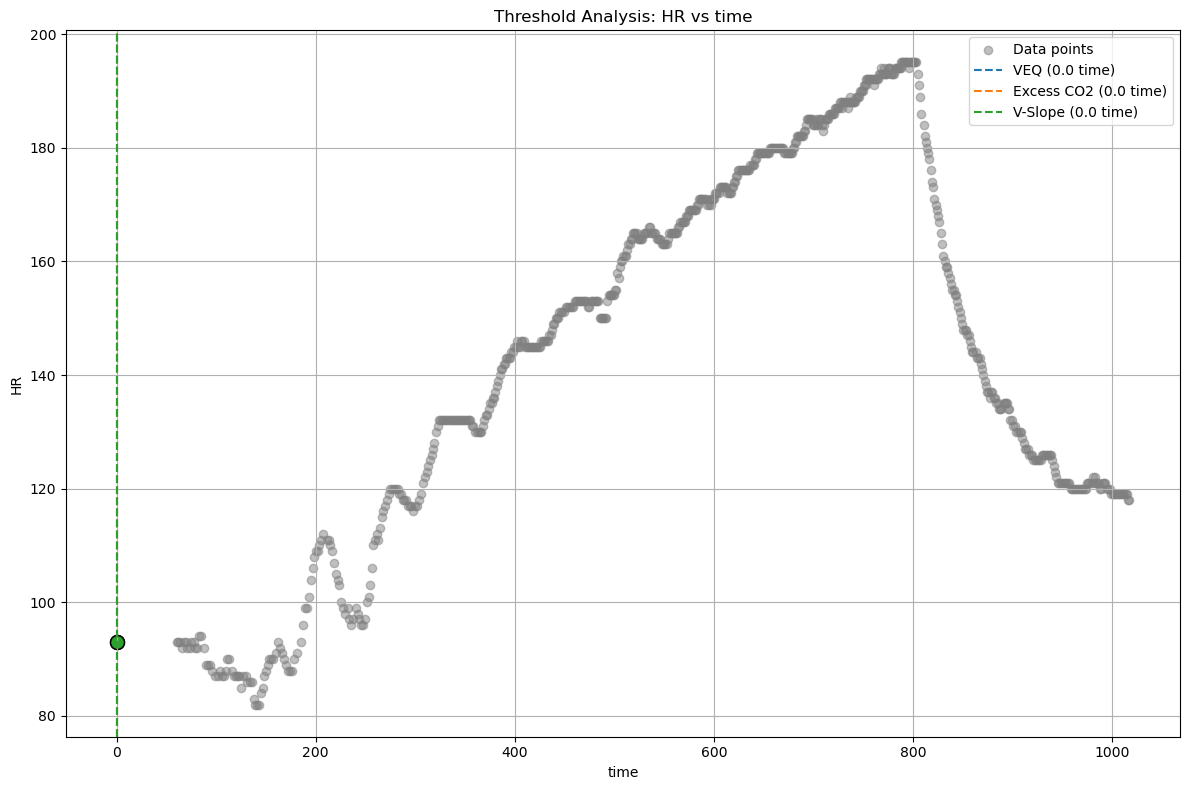

In [5]:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import IsolationForest
    from scipy.signal import savgol_filter
    from matplotlib.patches import Ellipse

    CONTAMINATION_LEVEL = 0.10 
    INITIAL_IGNORE_TIME = 60 

    def load_data(data_path, test_id):
        """Load and prepare the dataset"""
        data = pd.read_csv(data_path)
        subset = data[data['ID_test'] == test_id].sort_values('time')

        # Apply initial time exclusion
        if INITIAL_IGNORE_TIME > 0:
            subset = subset[subset['time'] >= INITIAL_IGNORE_TIME]

        subset = subset.dropna(subset=['VO2', 'VE', 'VCO2', 'time'])
        return subset


    def veq_method(data, show_plot=False):
        """Method 1: VEQ Method"""
        # Filter anomalies
        features = data[['VO2', 'VE']].values
        iso_forest = IsolationForest(contamination=CONTAMINATION_LEVEL, random_state=42)
        outlier_labels = iso_forest.fit_predict(features)
        filtered_data = data[outlier_labels == 1]

        x = filtered_data['VO2'].values
        y = filtered_data['VE'].values

        # Find best split point
        def find_best_split(x, y, min_points=5):
            best_split, min_error = None, float('inf')
            for i in range(min_points, len(x) - min_points):
                model1 = LinearRegression().fit(x[:i].reshape(-1,1), y[:i])
                model2 = LinearRegression().fit(x[i:].reshape(-1,1), y[i:])
                total_error = (
                    np.sum((y[:i] - model1.predict(x[:i].reshape(-1, 1)))**2) +
                    np.sum((y[i:] - model2.predict(x[i:].reshape(-1, 1)))**2)
                )

                if total_error < min_error:
                    min_error = total_error
                    best_split = i
            return best_split

        split_idx = find_best_split(x, y)
        vt_vo2 = x[split_idx] if split_idx is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(x, y, color='blue', label='Filtered Data')
            if vt_vo2:
                plt.axvline(vt_vo2, color='red', linestyle='--', label='VEQ VT')
            plt.xlabel('VO2')
            plt.ylabel('VE')
            plt.title('VEQ Method')
            plt.legend()
            plt.show()

        return vt_vo2

    def excess_co2_method(data, show_plot=False):
        """Method 2: Excess CO2 Method"""
        vo2 = data['VO2'].values
        vco2 = data['VCO2'].values
        ve = data['VE'].values

        # Calculate excess CO2
        vo2_safe = vo2.copy().astype(float)
        vo2_safe[vo2_safe == 0] = 1e-8
        exco2 = np.where((vco2 == 0) & (vo2 == 0), 0, (vco2**2 / vo2_safe) - vco2)
        exco2 = np.nan_to_num(exco2, nan=0.0, posinf=0.0, neginf=0.0)

        # Smooth and find threshold
        window_size = min(7, len(vo2)//2*2-1)
        exco2_smooth = savgol_filter(exco2, window_size, 2)
        threshold = np.median(exco2_smooth) + 0.5*np.std(exco2_smooth)
        vt_idx = np.argmax(exco2_smooth > threshold) if np.any(exco2_smooth > threshold) else None
        vt_vo2 = vo2[vt_idx] if vt_idx is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(vo2, ve, c='darkred', label='VE vs VO2')
            if vt_vo2:
                plt.axvline(vt_vo2, color='purple', linestyle='--', label='ExCO2 VT')
            plt.title('Excess CO2 Method')
            plt.legend()
            plt.show()

        return vt_vo2

    def v_slope_method(data, show_plot=False):

        """Method 3: Modified V-slope Method"""
        # 20-second averaging
        data = data.sort_values('time')
        data['VO2_20s'] = data['VO2'].rolling(window=25, min_periods=10, center=True).mean()
        data['VCO2_20s'] = data['VCO2'].rolling(window=25, min_periods=10, center=True).mean()
        data = data.dropna(subset=['VO2_20s', 'VCO2_20s'])

    #     features = data[['VO2_20s', 'VCO2_20s']].values
    #     iso_forest = IsolationForest(contamination=0.10, random_state=42)
    #     outlier_labels = iso_forest.fit_predict(features)
    #     filtered_data = data[outlier_labels == 1]
    #     data = filtered_data

        # Find slope breakpoint
        def find_slope_breakpoint(df):
            X = df['VO2_20s'].values.reshape(-1, 1)
            y = df['VCO2_20s'].values
            best_break, min_bic = None, float('inf')
            min_idx, max_idx = int(len(X)*0.2), len(X) - int(len(X)*0.2)

            for i in range(min_idx, max_idx):
                m1 = LinearRegression().fit(X[:i], y[:i])
                m2 = LinearRegression().fit(X[i:], y[i:])
                resid = np.concatenate([y[:i] - m1.predict(X[:i]), y[i:] - m2.predict(X[i:])])
                sigma2 = np.var(resid)
                bic = len(resid)*np.log(sigma2) + 2*np.log(len(resid))

                if (m2.coef_[0] > m1.coef_[0]) and (bic < min_bic):
                    min_bic = bic
                    best_break = i

            return df.iloc[best_break] if best_break is not None else None

        vt_point = find_slope_breakpoint(data)
        vt_vo2 = vt_point['VO2_20s'] if vt_point is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(data['VO2_20s'], data['VCO2_20s'], c=data['time'], cmap='viridis')
            if vt_point is not None:
                plt.scatter(vt_vo2, vt_point['VCO2_20s'], color='red', s=150, marker='*')
            plt.title('V-Slope Method')
            plt.show()

        return vt_vo2

    def calculate_average_threshold(results):
        """Calculate average of detected thresholds"""
        valid_thresholds = [vt for vt in results.values() if vt is not None]
        if not valid_thresholds:
            return None
        return np.mean(valid_thresholds)

    def plot_analysis(data, results, x_col='VO2', y_col='VE', plot_average=True):
        """
        Parameters:
        - data: DataFrame containing the data
        - results: Dictionary of threshold detection results {method_name: threshold_value}
        - x_col: Column name for x-axis (default 'VO2')
        - y_col: Column name for y-axis (default 'VE')
        - plot_average: Whether to plot the average threshold (default True)
        """
        plt.figure(figsize=(12, 8))

        # Plot main data
        plt.scatter(data[x_col], data[y_col], color='gray', alpha=0.5, label='Data points')

        # Plot each method's threshold
        colors = plt.cm.tab10.colors  # Use a colormap for consistent colors
        for i, (method, threshold) in enumerate(results.items()):
            if threshold is not None:
                # Find corresponding y value for the threshold
                idx = np.abs(data[x_col] - threshold).argmin()
                y_val = data.iloc[idx][y_col]

                plt.axvline(threshold, color=colors[i], linestyle='--', 
                           label=f'{method} ({threshold:.1f} {x_col})')
                plt.scatter(threshold, y_val, color=colors[i], s=100, edgecolor='k')

        # Calculate and plot average threshold if requested
        if plot_average:
            valid_thresholds = [t for t in results.values() if t is not None]
            if valid_thresholds:
                avg_threshold = np.mean(valid_thresholds)
                idx = np.abs(data[x_col] - avg_threshold).argmin()
                y_val = data.iloc[idx][y_col]

                plt.axvline(avg_threshold, color='purple', alpha=0.3, linewidth=4)
                plt.scatter(avg_threshold, y_val, color='purple', s=300, 
                           marker='*', edgecolor='k', 
                           label=f'Average ({avg_threshold:.1f} {x_col})')

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'Threshold Analysis: {y_col} vs {x_col}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def main():
        # Load data
        data_path = 'test_measure.csv'
        test_id = "610_1" # CHANGING ID HERE 
        data = load_data(data_path, test_id)

        # Run all methods
        results = {
            'VEQ': veq_method(data),
            'Excess CO2': excess_co2_method(data),
            'V-Slope': v_slope_method(data)
        }

        # Print results
        print("Ventilatory Threshold Results:")
        for method, vt in results.items():
            print(f"{method}: {vt:.1f} mL/min" if vt else f"{method}: Not detected")

        # Plot comparison
        plot_analysis(data, results, x_col='VO2', y_col='VCO2', plot_average=True)
        plot_analysis(data, results, x_col='VO2', y_col='VE', plot_average=True)
        plot_analysis(data,{'VEQ': 0,'Excess CO2': 0,'V-Slope': 0}, x_col='time', y_col='HR', plot_average=False)

    if __name__ == "__main__":
        main()

Ventilatory Threshold Results:
VEQ: 2009.0 mL/min
Excess CO2: 2847.0 mL/min
V-Slope: 2831.2 mL/min


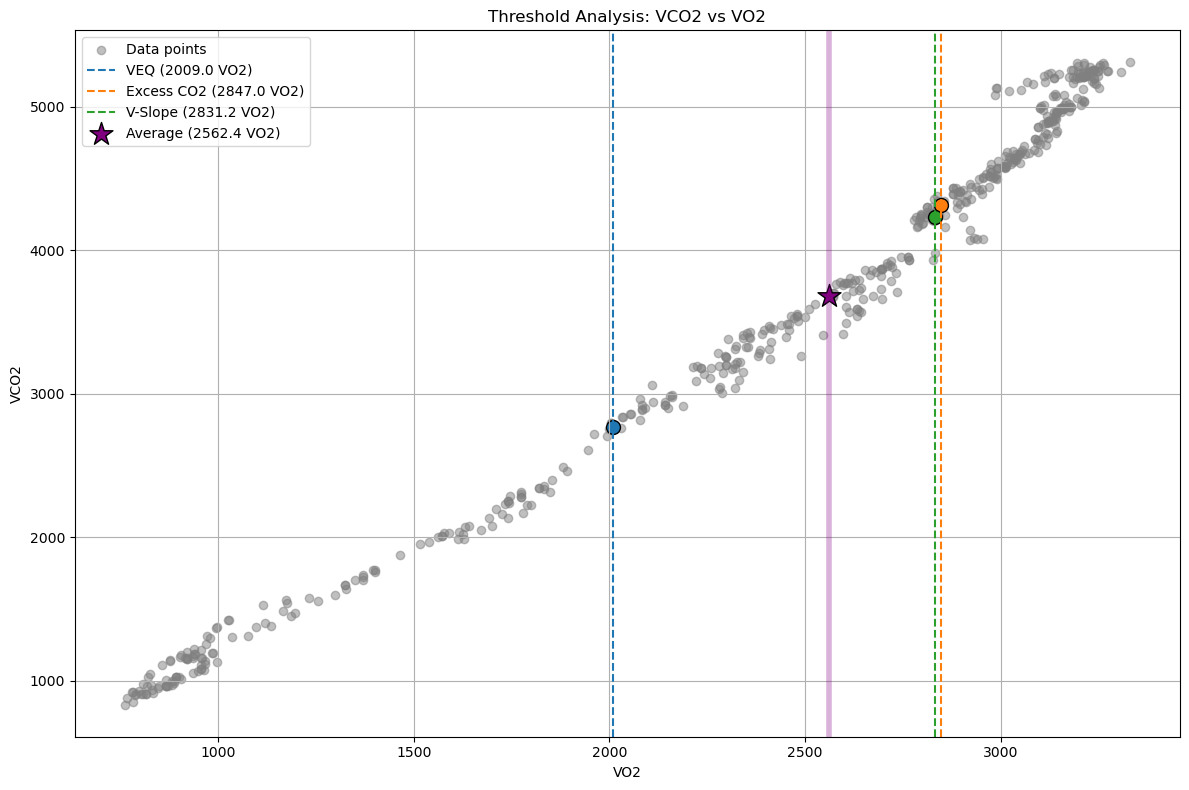

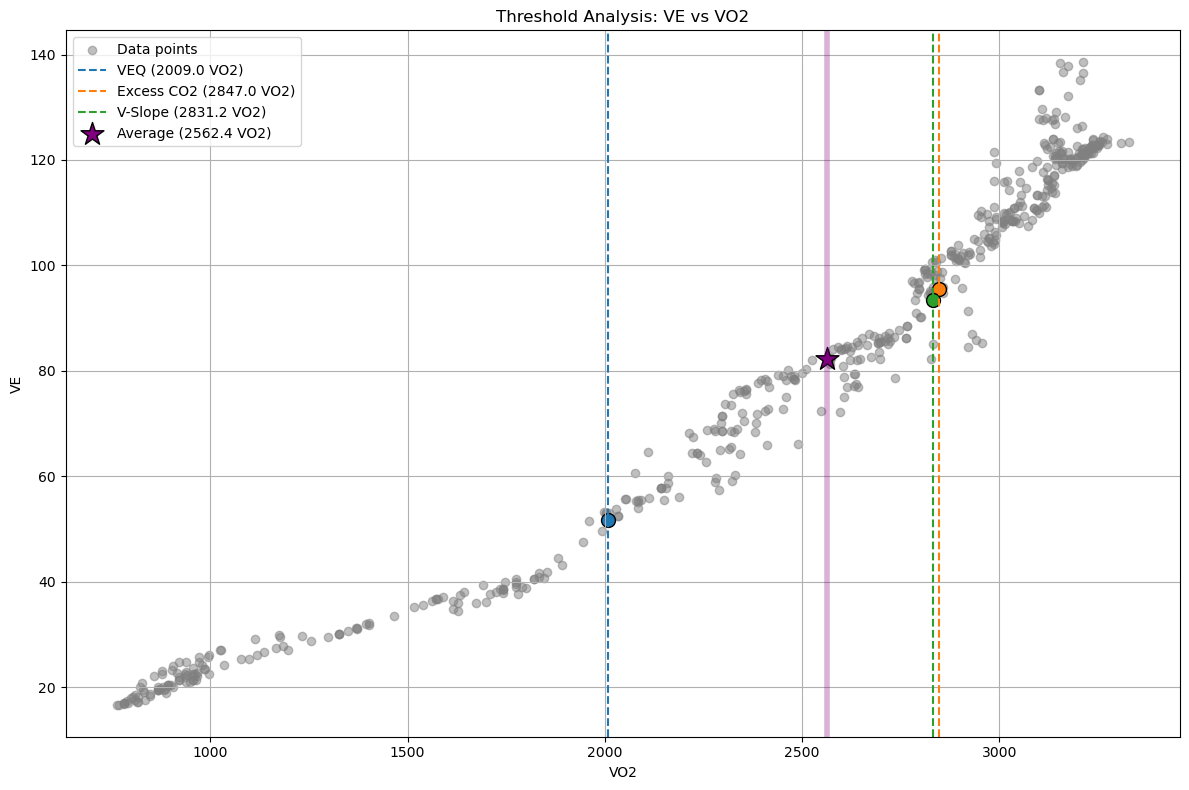

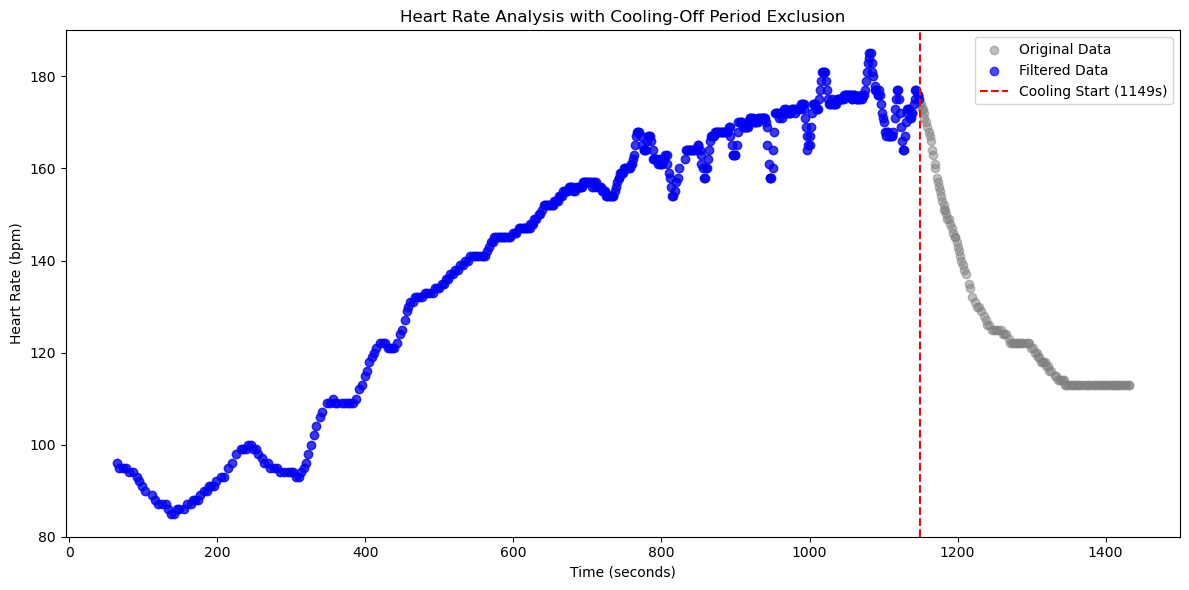

In [13]:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import IsolationForest
    from scipy.signal import savgol_filter

    # Constants
    CONTAMINATION_LEVEL = 0.15
    INITIAL_IGNORE_TIME = 60  # seconds
    COOLING_DROP_PCT = 5  # percentage drop from max HR to trigger cooling period
    COOLING_MIN_DURATION = 30  # seconds

    def load_data(data_path, test_id):
        """Load and prepare the dataset, returns data_before_cooling and cooling_start_time"""
        data = pd.read_csv(data_path)
        subset = data[data['ID_test'] == test_id].sort_values('time')

        # Apply initial time exclusion
        if INITIAL_IGNORE_TIME > 0:
            subset = subset[subset['time'] >= INITIAL_IGNORE_TIME]

        # Drop rows with missing essential values including HR
        subset = subset.dropna(subset=['VO2', 'VE', 'VCO2', 'time', 'HR'])

        # Detect cooling-off period based on HR drop
        times = subset['time'].values
        hr = subset['HR'].values
        cooling_start_time = None

        if len(hr) < 3:
            return subset, cooling_start_time  # Not enough data for analysis

        # Smooth HR data
        window_size = min(11, len(hr))
        if window_size % 2 == 0:
            window_size -= 1  # Ensure window size is odd
        if window_size >= 3:
            smoothed_hr = savgol_filter(hr, window_size, 2)
        else:
            smoothed_hr = hr

        max_hr_idx = np.argmax(smoothed_hr)
        max_hr = smoothed_hr[max_hr_idx]
        threshold_hr = max_hr * (1 - COOLING_DROP_PCT / 100)

        # Find cooling start time
        for i in range(max_hr_idx, len(times)):
            current_time = times[i]
            if smoothed_hr[i] < threshold_hr:
                end_time = current_time + COOLING_MIN_DURATION
                mask = (times >= current_time) & (times <= end_time)
                if len(smoothed_hr[mask]) == 0:
                    continue
                if np.all(smoothed_hr[mask] < threshold_hr):
                    cooling_start_time = current_time
                    break

        return subset, cooling_start_time


    def veq_method(data, show_plot=False):
        """Method 1: VEQ Method"""
        # Filter anomalies
        features = data[['VO2', 'VE']].values
        iso_forest = IsolationForest(contamination=CONTAMINATION_LEVEL, random_state=42)
        outlier_labels = iso_forest.fit_predict(features)
        filtered_data = data[outlier_labels == 1]

        x = filtered_data['VO2'].values
        y = filtered_data['VE'].values

        # Find best split point
        def find_best_split(x, y, min_points=5):
            best_split, min_error = None, float('inf')
            for i in range(min_points, len(x) - min_points):
                model1 = LinearRegression().fit(x[:i].reshape(-1,1), y[:i])
                model2 = LinearRegression().fit(x[i:].reshape(-1,1), y[i:])
                total_error = (
                    np.sum((y[:i] - model1.predict(x[:i].reshape(-1, 1)))**2) +
                    np.sum((y[i:] - model2.predict(x[i:].reshape(-1, 1)))**2)
                )

                if total_error < min_error:
                    min_error = total_error
                    best_split = i
            return best_split

        split_idx = find_best_split(x, y)
        vt_vo2 = x[split_idx] if split_idx is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(x, y, color='blue', label='Filtered Data')
            if vt_vo2:
                plt.axvline(vt_vo2, color='red', linestyle='--', label='VEQ VT')
            plt.xlabel('VO2')
            plt.ylabel('VE')
            plt.title('VEQ Method')
            plt.legend()
            plt.show()

        return vt_vo2

    def excess_co2_method(data, show_plot=False):
        """Method 2: Excess CO2 Method"""
        vo2 = data['VO2'].values
        vco2 = data['VCO2'].values
        ve = data['VE'].values

        # Calculate excess CO2
        vo2_safe = vo2.copy().astype(float)
        vo2_safe[vo2_safe == 0] = 1e-8
        exco2 = np.where((vco2 == 0) & (vo2 == 0), 0, (vco2**2 / vo2_safe) - vco2)
        exco2 = np.nan_to_num(exco2, nan=0.0, posinf=0.0, neginf=0.0)

        # Smooth and find threshold
        window_size = min(7, len(vo2)//2*2-1)
        exco2_smooth = savgol_filter(exco2, window_size, 2)
        threshold = np.median(exco2_smooth) + 0.5*np.std(exco2_smooth)
        vt_idx = np.argmax(exco2_smooth > threshold) if np.any(exco2_smooth > threshold) else None
        vt_vo2 = vo2[vt_idx] if vt_idx is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(vo2, ve, c='darkred', label='VE vs VO2')
            if vt_vo2:
                plt.axvline(vt_vo2, color='purple', linestyle='--', label='ExCO2 VT')
            plt.title('Excess CO2 Method')
            plt.legend()
            plt.show()

        return vt_vo2

    def v_slope_method(data, show_plot=False):

        """Method 3: Modified V-slope Method"""
        # 20-second averaging
        data = data.sort_values('time')
        data['VO2_20s'] = data['VO2'].rolling(window=25, min_periods=10, center=True).mean()
        data['VCO2_20s'] = data['VCO2'].rolling(window=25, min_periods=10, center=True).mean()
        data = data.dropna(subset=['VO2_20s', 'VCO2_20s'])

    #     features = data[['VO2_20s', 'VCO2_20s']].values
    #     iso_forest = IsolationForest(contamination=0.10, random_state=42)
    #     outlier_labels = iso_forest.fit_predict(features)
    #     filtered_data = data[outlier_labels == 1]
    #     data = filtered_data

        # Find slope breakpoint
        def find_slope_breakpoint(df):
            X = df['VO2_20s'].values.reshape(-1, 1)
            y = df['VCO2_20s'].values
            best_break, min_bic = None, float('inf')
            min_idx, max_idx = int(len(X)*0.2), len(X) - int(len(X)*0.2)

            for i in range(min_idx, max_idx):
                m1 = LinearRegression().fit(X[:i], y[:i])
                m2 = LinearRegression().fit(X[i:], y[i:])
                resid = np.concatenate([y[:i] - m1.predict(X[:i]), y[i:] - m2.predict(X[i:])])
                sigma2 = np.var(resid)
                bic = len(resid)*np.log(sigma2) + 2*np.log(len(resid))

                if (m2.coef_[0] > m1.coef_[0]) and (bic < min_bic):
                    min_bic = bic
                    best_break = i

            return df.iloc[best_break] if best_break is not None else None

        vt_point = find_slope_breakpoint(data)
        vt_vo2 = vt_point['VO2_20s'] if vt_point is not None else None

        if show_plot:
            plt.figure()
            plt.scatter(data['VO2_20s'], data['VCO2_20s'], c=data['time'], cmap='viridis')
            if vt_point is not None:
                plt.scatter(vt_vo2, vt_point['VCO2_20s'], color='red', s=150, marker='*')
            plt.title('V-Slope Method')
            plt.show()

        return vt_vo2

    def calculate_average_threshold(results):
        """Calculate average of detected thresholds"""
        valid_thresholds = [vt for vt in results.values() if vt is not None]
        if not valid_thresholds:
            return None
        return np.mean(valid_thresholds)

    def plot_analysis(data, results, x_col='VO2', y_col='VE', plot_average=True):
        """
        Parameters:
        - data: DataFrame containing the data
        - results: Dictionary of threshold detection results {method_name: threshold_value}
        - x_col: Column name for x-axis (default 'VO2')
        - y_col: Column name for y-axis (default 'VE')
        - plot_average: Whether to plot the average threshold (default True)
        """
        plt.figure(figsize=(12, 8))

        # Plot main data
        plt.scatter(data[x_col], data[y_col], color='gray', alpha=0.5, label='Data points')

        # Plot each method's threshold
        colors = plt.cm.tab10.colors  # Use a colormap for consistent colors
        for i, (method, threshold) in enumerate(results.items()):
            if threshold is not None:
                # Find corresponding y value for the threshold
                idx = np.abs(data[x_col] - threshold).argmin()
                y_val = data.iloc[idx][y_col]

                plt.axvline(threshold, color=colors[i], linestyle='--', 
                           label=f'{method} ({threshold:.1f} {x_col})')
                plt.scatter(threshold, y_val, color=colors[i], s=100, edgecolor='k')

        # Calculate and plot average threshold if requested
        if plot_average:
            valid_thresholds = [t for t in results.values() if t is not None]
            if valid_thresholds:
                avg_threshold = np.mean(valid_thresholds)
                idx = np.abs(data[x_col] - avg_threshold).argmin()
                y_val = data.iloc[idx][y_col]

                plt.axvline(avg_threshold, color='purple', alpha=0.3, linewidth=4)
                plt.scatter(avg_threshold, y_val, color='purple', s=300, 
                           marker='*', edgecolor='k', 
                           label=f'Average ({avg_threshold:.1f} {x_col})')

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f'Threshold Analysis: {y_col} vs {x_col}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def main():
        # Load data
        data_path = 'test_measure.csv'
        test_id = "711_1"
        data_before_cooling, cooling_start_time = load_data(data_path, test_id)

        # Apply cooling period exclusion
        if cooling_start_time is not None:
            data = data_before_cooling[data_before_cooling['time'] < cooling_start_time]
        else:
            data = data_before_cooling.copy()

        # Run all methods
        results = {
            'VEQ': veq_method(data),
            'Excess CO2': excess_co2_method(data),
            'V-Slope': v_slope_method(data)
        }

        # Print results
        print("Ventilatory Threshold Results:")
        for method, vt in results.items():
            print(f"{method}: {vt:.1f} mL/min" if vt else f"{method}: Not detected")

        # Plot analyses
        plot_analysis(data, results, x_col='VO2', y_col='VCO2', plot_average=True)
        plot_analysis(data, results, x_col='VO2', y_col='VE', plot_average=True)

        # Plot HR comparison
        plt.figure(figsize=(12, 6))
        plt.scatter(data_before_cooling['time'], data_before_cooling['HR'], 
                    color='gray', alpha=0.5, label='Original Data')
        plt.scatter(data['time'], data['HR'], 
                    color='blue', alpha=0.7, label='Filtered Data')
        if cooling_start_time is not None:
            plt.axvline(cooling_start_time, color='red', linestyle='--', 
                        label=f'Cooling Start ({cooling_start_time:.0f}s)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Heart Rate (bpm)')
        plt.title('Heart Rate Analysis with Cooling-Off Period Exclusion')
        plt.legend()
        plt.tight_layout()
        plt.show()

    if __name__ == "__main__":
        main()